<a href="https://colab.research.google.com/github/JCaballerot/Recommender_Systems/blob/main/K_Nearest_Neighbors_Recommender/MovieLens_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalar la librería scikit-surprise para algoritmos de filtrado colaborativo
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357280 sha256=6cc1b05eaa336ab92c0b64e5040bbe44051102f92dee087a822415f5b6bc06d1
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [3]:
# Descargar el dataset MovieLens 1M
!curl -o dataset.zip "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
!unzip dataset.zip
!ls -la


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5778k  100 5778k    0     0  12.9M      0 --:--:-- --:--:-- --:--:-- 12.9M
Archive:  dataset.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
total 5800
drwxr-xr-x 1 root root    4096 Oct 29 00:33 .
drwxr-xr-x 1 root root    4096 Oct 29 00:24 ..
drwxr-xr-x 4 root root    4096 Oct 25 13:20 .config
-rw-r--r-- 1 root root 5917549 Oct 29 00:33 dataset.zip
drwxr-x--- 2 root root    4096 Jan 29  2016 ml-1m
drwxr-xr-x 1 root root    4096 Oct 25 13:20 sample_data


In [2]:
import pandas as pd
import matplotlib.pyplot as plt


In [5]:
# Cargar los datasets de calificaciones y películas
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', header=None, engine='python',
                      names=['userId', 'movieId', 'rating', 'timestamp'], encoding='latin-1')
movies  = pd.read_csv('ml-1m/movies.dat', sep='::',  header=None, engine='python',
                      names=['movieId', 'title', 'genres'], encoding='latin-1')


In [6]:
# Unir los datasets en base a 'movieId' para agregar los títulos
user_item_rating = pd.merge(ratings, movies[['movieId', 'title']], on='movieId')

# Seleccionar solo las columnas necesarias
user_item_rating = user_item_rating[['userId', 'title', 'rating']]

# Ordenar los datos por 'userId'
user_item_rating.sort_values(by='userId', inplace=True)

# Mostrar las primeras filas para verificar
user_item_rating.head()


,userId,title,rating
0,1,One Flew Over the Cuckoo's Nest (1975),5
29,1,"Close Shave, A (1995)",3
30,1,Antz (1998),4
31,1,"Girl, Interrupted (1999)",4
32,1,Hercules (1997),4


In [7]:
# Dimensiones del dataset
print(f"El dataset tiene {user_item_rating.shape[0]} calificaciones.")


El dataset tiene 1000209 calificaciones.


In [8]:
# Número de usuarios únicos
num_users = ratings['userId'].nunique()
print(f"Hay {num_users} usuarios únicos.")

# Número de películas únicas
num_movies = ratings['movieId'].nunique()
print(f"Hay {num_movies} películas únicas.")


Hay 6040 usuarios únicos.
Hay 3706 películas únicas.


**PREGUNTA 2**

In [33]:
# Filtrar usuarios que hayan calificado al menos 5 películas en común con otros usuarios
# Crear una tabla de usuario-item con las calificaciones
user_movie_matrix = user_item_rating.pivot_table(index='userId', columns='title', values='rating')


In [34]:
# Llenar NaN con 0 temporalmente para evitar errores en el cálculo de similitud
user_movie_matrix_filled = user_movie_matrix.fillna(0)

In [35]:
user_movie_matrix_filled.shape

(6040, 3706)

In [36]:
user_movie_matrix_filled = user_movie_matrix_filled.sample(n=500)

In [37]:
# Encontrar pares de usuarios que tengan al menos 5 películas en común
user_pairs = []
for i, user1 in enumerate(user_movie_matrix_filled.index):
    for j, user2 in enumerate(user_movie_matrix_filled.index):
        if user1 >= user2:
            continue
        # Seleccionar películas en común (sin considerar valoraciones nulas)
        common_movies = user_movie_matrix.loc[user1].dropna().index.intersection(
            user_movie_matrix.loc[user2].dropna().index)

        if len(common_movies) >= 5:
            user_pairs.append((user1, user2))


In [38]:
print(user_pairs)

[(1674, 5184), (1674, 5788), (1674, 4868), (1674, 4451), (1674, 5172), (1674, 5760), (1674, 1744), (1674, 4225), (1674, 2695), (1674, 5037), (1674, 2689), (1674, 4473), (1674, 3018), (1674, 1861), (1674, 3886), (1674, 3281), (1674, 3749), (1674, 3950), (1674, 3705), (1674, 4781), (1674, 1752), (1674, 3250), (1674, 1709), (1674, 5812), (1674, 3157), (1674, 3751), (1674, 3425), (1674, 2895), (1674, 3532), (1674, 3013), (1674, 5519), (1674, 2849), (1674, 5890), (1674, 3509), (1674, 4736), (1674, 5249), (1674, 3451), (1674, 4845), (1674, 1767), (1674, 5795), (1674, 5394), (1674, 5759), (1674, 4662), (1674, 5100), (1674, 4122), (1674, 2290), (1674, 5005), (1674, 4989), (1674, 4505), (1674, 1962), (1674, 5980), (1674, 5857), (1674, 5260), (1674, 5847), (1674, 4887), (1674, 4578), (1674, 1806), (1674, 4036), (1674, 5004), (1674, 3112), (1674, 5387), (1674, 5893), (1674, 4771), (1674, 5091), (1674, 4524), (1674, 4814), (1674, 2986), (1674, 5896), (1674, 4834), (1674, 5880), (1674, 2700), (1674

In [39]:
import numpy as np
import random
from scipy.stats import pearsonr

# Elegir dos usuarios al azar de los pares obtenidos
selected_pair = random.choice(user_pairs)
user1, user2 = selected_pair
print(selected_pair)

(1243, 3293)


In [44]:
user_movie_matrix = user_movie_matrix.fillna(0)

In [45]:
# Extraer las valoraciones de las películas en común de ambos usuarios
user1_ratings = user_movie_matrix.loc[user1, common_movies]
user2_ratings = user_movie_matrix.loc[user2, common_movies]
print(user1_ratings)
print(user2_ratings)

title
2001: A Space Odyssey (1968)                                          4.0
Adventures of Buckaroo Bonzai Across the 8th Dimension, The (1984)    0.0
Aladdin (1992)                                                        0.0
As Good As It Gets (1997)                                             0.0
Back to the Future (1985)                                             4.0
                                                                     ... 
Truth About Cats & Dogs, The (1996)                                   3.0
Twelve Monkeys (1995)                                                 5.0
When Harry Met Sally... (1989)                                        4.0
Who Framed Roger Rabbit? (1988)                                       0.0
Willow (1988)                                                         0.0
Name: 1243, Length: 81, dtype: float64
title
2001: A Space Odyssey (1968)                                          0.0
Adventures of Buckaroo Bonzai Across the 8th Dimension, The (

In [46]:
# Calcular la similitud usando la correlación de Pearson
correlation, _ = pearsonr(user1_ratings, user2_ratings)
print(f"Similitud entre el usuario {user1} y el usuario {user2}: {correlation:.2f}")

Similitud entre el usuario 1243 y el usuario 3293: -0.03


**Interpretación**: Esta similitud indica que los usuarios tienen gustos dispares y, es decir las recomendaciones basadas en uno de ellos podrían no ser deseadas para el otro o irrelevantes.

**PREGUNTA 3**

In [47]:
# Contar cuántas veces ha sido calificada cada película
item_rating_counts = user_item_rating['title'].value_counts()

In [49]:
# Establecer el mínimo de calificaciones por película
min_ratings_per_movie = 50

# Filtrar las películas con al menos min_ratings_per_movie calificaciones
movie_counts = user_item_rating['title'].value_counts()
popular_movies = movie_counts[movie_counts >= min_ratings_per_movie].index

# Filtrar el dataset original
filtered_data = user_item_rating[user_item_rating['title'].isin(popular_movies)]
filtered_data.head()


,userId,title,rating
0,1,One Flew Over the Cuckoo's Nest (1975),5
29,1,"Close Shave, A (1995)",3
30,1,Antz (1998),4
31,1,"Girl, Interrupted (1999)",4
32,1,Hercules (1997),4


In [50]:
# Crear una matriz usuario-película para el cálculo de similitudes
user_movie_matrix = filtered_data.pivot_table(index='userId', columns='title', values='rating').fillna(0)


In [53]:
selected_movie = popular_movies[0]
other_movies = popular_movies[1:3]

In [54]:
selected_movie_vector = user_movie_matrix[selected_movie].values.reshape(1, -1)
other_movie_vectors = [user_movie_matrix[other_movie].values.reshape(1, -1) for other_movie in other_movies]


In [56]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarities = [
    cosine_similarity(selected_movie_vector, other_movie_vector)[0][0]
    for other_movie_vector in other_movie_vectors
]

In [57]:
print(f"Película seleccionada: {selected_movie}")
for i, other_movie in enumerate(other_movies):
    print(f"Similitud coseno entre '{selected_movie}' y '{other_movie}': {cosine_similarities[i]:.2f}")

Película seleccionada: American Beauty (1999)
Similitud coseno entre 'American Beauty (1999)' y 'Star Wars: Episode IV - A New Hope (1977)': 0.54
Similitud coseno entre 'American Beauty (1999)' y 'Star Wars: Episode V - The Empire Strikes Back (1980)': 0.55


La similitud generada puede ayudar para recomendar peliculas relacionadas. En este caso si a un usuario le gusto la pelicula American Beauty podria presentar interes en peliculas de Star Wars. Este valor puede representar que los usuarios tienen afinidad por titulos que son inusuales para ellos. Adicionalmente la similitud coseno puede generar diversificacion es decir evita recomendaciones enfocadas en determinados generos como en este caso.

**PREGUNTA 4**

In [58]:
# Número de películas únicas después del filtrado
num_filtered_movies = filtered_data['title'].nunique()
print(f"Después del filtrado, hay {num_filtered_movies} películas.")


Después del filtrado, hay 2514 películas.


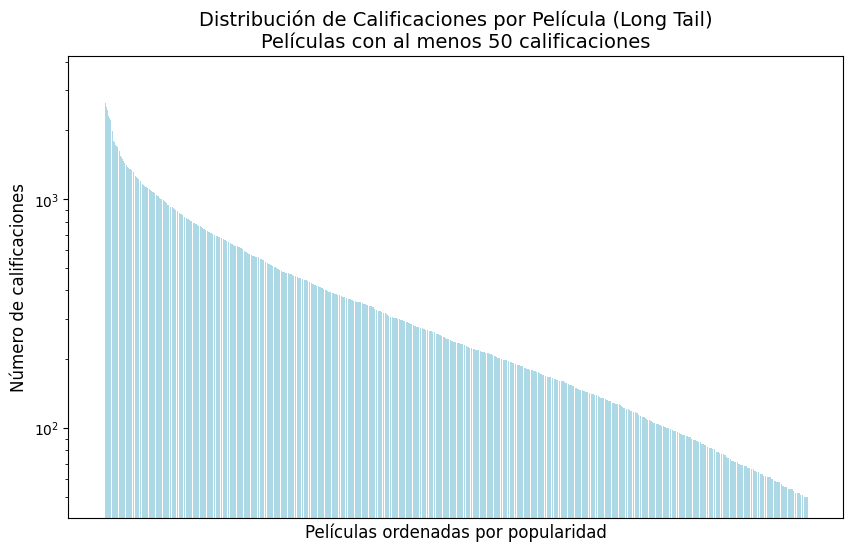

In [63]:
# Contar calificaciones por película en datos filtrados
filtered_movie_rating_counts = filtered_data['title'].value_counts()

# Gráfico de barras para visualizar el long tail filtrado
plt.figure(figsize=(10, 6))
plt.bar(range(len(filtered_movie_rating_counts)), filtered_movie_rating_counts, color='lightblue')
plt.title(f'Distribución de Calificaciones por Película (Long Tail)\nPelículas con al menos {min_ratings_per_movie} calificaciones', fontsize=14)
plt.xlabel('Películas ordenadas por popularidad', fontsize=12)
plt.ylabel('Número de calificaciones', fontsize=12)
plt.yscale('log')
plt.xticks([], [])
plt.show()


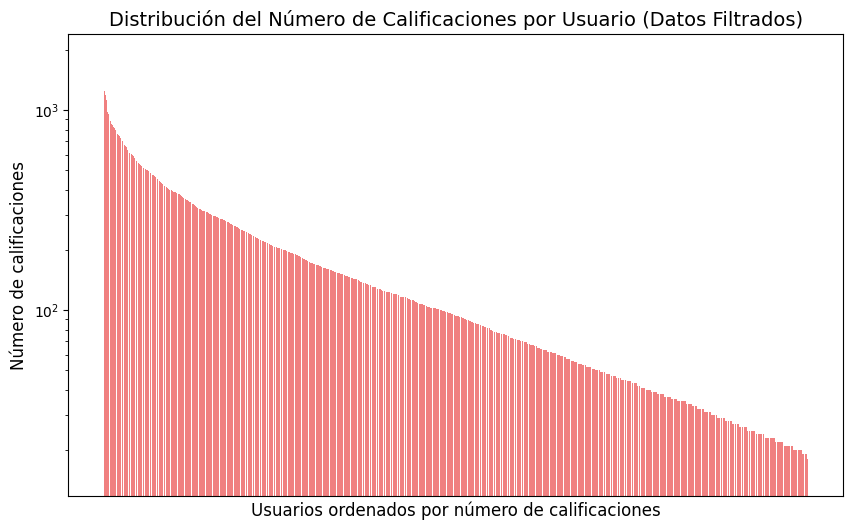

In [64]:
# Contar cuántas películas ha calificado cada usuario
user_rating_counts_filtered = filtered_data['userId'].value_counts()

# Gráfico de barras para visualizar calificaciones por usuario
plt.figure(figsize=(10, 6))
plt.bar(range(len(user_rating_counts_filtered)), user_rating_counts_filtered, color='lightcoral')
plt.title('Distribución del Número de Calificaciones por Usuario (Datos Filtrados)', fontsize=14)
plt.xlabel('Usuarios ordenados por número de calificaciones', fontsize=12)
plt.ylabel('Número de calificaciones', fontsize=12)
plt.yscale('log')
plt.xticks([], [])
plt.show()


In [65]:
# Crear la matriz usuario-ítem
user_item_matrix = filtered_data.pivot_table(index='userId', columns='title', values='rating')

# Ordenar los IDs de usuario por cantidad de calificaciones
sorted_user_ids = user_rating_counts_filtered.index

# Ordenar la matriz según usuarios más activos
user_item_matrix_sorted = user_item_matrix.loc[sorted_user_ids]
user_item_matrix_sorted.head()


title,'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),"13th Warrior, The (1999)",187 (1997),...,You've Got Mail (1998),Young Doctors in Love (1982),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Your Friends and Neighbors (1998),Zero Effect (1998),eXistenZ (1999)
userId,,,,,,,,,,,,,,,,,,,,,
4169,5.0,NaN,NaN,3.0,NaN,4.0,4.0,5.0,4.0,3.0,...,4.0,NaN,4.0,3.0,3.0,NaN,3.0,3.0,3.0,4.0
1680,5.0,3.0,3.0,5.0,NaN,5.0,3.0,NaN,1.0,NaN,...,4.0,4.0,5.0,1.0,1.0,NaN,3.0,5.0,4.0,5.0
4277,NaN,NaN,NaN,5.0,NaN,4.0,NaN,5.0,4.0,NaN,...,NaN,3.0,5.0,4.0,3.0,2.0,4.0,NaN,5.0,4.0
1941,NaN,NaN,1.0,NaN,2.0,5.0,3.0,5.0,1.0,NaN,...,3.0,3.0,4.0,4.0,3.0,NaN,3.0,NaN,NaN,NaN
1181,NaN,NaN,NaN,2.0,2.0,3.0,3.0,2.0,4.0,NaN,...,3.0,2.0,3.0,2.0,2.0,NaN,3.0,NaN,NaN,4.0


In [66]:
def Random_Holdout(df, test_size=0.25):
    """Divide los datos asegurando que cada usuario tenga al menos una interacción en el conjunto de entrenamiento"""
    # Seleccionar al azar un porcentaje de interacciones por usuario para entrenamiento
    train_df = df.groupby('userId').apply(lambda x: x.sample(frac=1 - test_size, random_state=42)).reset_index(drop=True)
    # El resto va al conjunto de prueba
    test_df = pd.concat([df, train_df]).drop_duplicates(keep=False)

    return train_df, test_df

# Aplicar la función al dataset filtrado
train_df, test_df = Random_Holdout(filtered_data, test_size=0.3)


<ipython-input-66-b971037283ec>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = df.groupby('userId').apply(lambda x: x.sample(frac=1 - test_size, random_state=42)).reset_index(drop=True)


In [67]:
from surprise import Dataset, Reader, KNNBasic, accuracy

# Definir el rango de calificaciones
reader = Reader(rating_scale=(1, 5))

# Cargar datos de entrenamiento
trainset = Dataset.load_from_df(train_df[['userId', 'title', 'rating']], reader).build_full_trainset()

# Crear conjunto de prueba
testset = list(test_df[['userId', 'title', 'rating']].itertuples(index=False, name=None))


In [69]:
# Configurar opciones del modelo KNN
sim_options = {
    'name': 'msd',  # Mean Squared Difference (distancia euclidiana)
    'user_based': True  # Filtrado Usuario-Usuario
}

# Crear el modelo KNN
knn = KNNBasic(k=50, sim_options=sim_options)

# Entrenar el modelo
knn.fit(trainset)


Computing the msd similarity matrix...
Done computing similarity matrix.
